# Shift fit apply global for IMSC

In [1]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), cartopy, openpyxl, (statsmodels?)

import numpy as np
import pandas as pd
import os, glob, re 
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import matplotlib.pyplot as plt
import netCDF4
from scipy.stats import norm


%matplotlib inline

#plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# import my variables settings functions from other scripts
from settings import *

# import fxns 
from functions import *
from utils import *
from plotscript import *

# import other packages/modules 

sys.path.append('../population/') # make this a module i can pip install and import ! 
from population_demographics_climate import * # move / rename this when good ! --> change to import demographics4climate as d4c


In [2]:
start_message() 

flags: {'models': 'ISIMIP3a', 'experiment': 'obsclim', 'metric': 'WBGT', 'method': 'shift_fit', 'time_method': None, 'shift_sigma': True, 'shift_period': None, 'chunk_version': 0, 'var': 'wbgt'}
var: wbgt
VARs: None
indir_p: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/InputData/climate/atmosphere/bias-adjusted/global/daily/
indir_s: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/
indir_obs: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/obsclim/global/daily/historical/
indir_counterclim: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/counterclim/global/daily/historical/
GCMs: ['CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0']
datasets: ['GSWP3-W5E5', '20CRv3-ERA5', '20CRv3-W5E5']
lat_chunk: 90
lon_chunk: 120
time_chunk: -1
outdirs: /data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output
fi

In [3]:
from dask.distributed import Client 
client = Client()
client

/apps/brussel/RL8/skylake/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41529 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:41529/status,
Dashboard: http://127.0.0.1:41529/status,Workers: 2
Total threads: 2,Total memory: 60.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40311,Workers: 2
Dashboard: http://127.0.0.1:41529/status,Total threads: 2
Started: Just now,Total memory: 60.00 GiB
Comm: tcp://127.0.0.1:37275,Total threads: 1
Dashboard: http://127.0.0.1:38239/status,Memory: 30.00 GiB
Nanny: tcp://127.0.0.1:35181,


In [1]:
figdir=os.path.join(figdirs, 'aug24_poster')

NameError: name 'os' is not defined

# Functions (to move)

In [4]:
# model mean and range (not IQR)

def plot_barplot_n_prop_people_atleastx_modelmean(da, 
                                                  unit, 
                                                  ax, 
                                                  year=2022, 
                                                  proportion=False, 
                                                  x_hot_days = [1,5,10,20,50],
                                                 legend=True,
                                                 errcolor='gray',
                                                 color=None,
                                                 title=True):
    # plot range 
    if unit == 1e9:
        unit_str = 'billions'
    elif unit == 1e6:
        unit_str='millions'
    else:
        unit_str = ''

    upper_error = (da.max(dim='model')-da.mean(dim='model')).values.T /unit
    lower_error = (da.mean(dim='model')-da.min(dim='model')).values.T /unit
    try:
        concatenated =np.concatenate((lower_error,upper_error), axis=1)
        reshaped = np.reshape(concatenated, (len(da.features), 2, len(da.age_ranges)))
    except:
        concatenated =np.concatenate((lower_error,upper_error))
        reshaped = np.reshape(concatenated, (2, len(da.age_ranges)))

    # plot multi-model mean 
    if color == None:
        (da.mean(dim='model')/unit).to_pandas().plot.bar(ax=ax,
                                                   yerr=reshaped,
                                                   error_kw=dict(ecolor=errcolor, alpha=1, elinewidth=.8, capsize=1))
    else:
        (da.mean(dim='model')/unit).to_pandas().plot.bar(ax=ax,
                                                   yerr=reshaped,
                                                         color=color,
                                                   error_kw=dict(ecolor=errcolor, alpha=1, elinewidth=.8, capsize=1))        
                          
    if proportion ==False:
        ax.set_ylabel(f'Number of people ({unit_str})')
        if title==True:
            ax.set_title(f'number of people experiencing at least n attributable hot days in {year}')
    else:
        ax.set_ylabel(f'Proportion of age group (%)')
        if title ==True:
            ax.set_title(f'proportion of age group experiencing at least n attributable hot days in {year}')
    
    ax.set_xlabel('Ages')
    step_ages = int(da.age_ranges[1] -da.age_ranges[0] - 1)
    ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+step_ages}' for x in da.age_ranges],  rotation='horizontal')
    if legend==True:
        ax.legend(labels = [f'at least {x}' for x in x_hot_days])

In [5]:
def plot_percapitadays_median_iqr(da, feature, ax):
    
    df_plot =  da.sel(features=feature).to_pandas()
    
    medianprops = dict(color='k',linewidth=2)
    whiskerprops = dict(color='none')
    capprops = dict(color='none')

    plot = ax.boxplot(df_plot,  
                      whiskerprops=whiskerprops, 
                      capprops=capprops, 
                      medianprops=medianprops,
                      patch_artist=True,
                      showfliers=False) #boxprops=boxprops,

    col='cadetblue'
    for patch in plot['boxes']:
            patch.set_facecolor(col)
            patch.set_edgecolor(col)

    ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+9}' for x in df_plot.columns], rotation='horizontal');
    plt.ylabel('Per capita attributable hot-humid days per year')
    plt.xlabel('Ages');

In [6]:
def df_summary_mean_range(da,feature,units):
    
    if units > 100:
        df_summary = da.sel(features=feature).to_pandas().T / units
    elif units == 100:
        df_summary = da.sel(features=feature).to_pandas().T * units
    elif units == None:
         df_summary = da.sel(features=feature).to_pandas().T
    df_summary['mean'] = df_summary.iloc[:,0:6].mean(axis=1)
    df_summary['min'] = df_summary.iloc[:,0:6].min(axis=1)
    df_summary['max'] = df_summary.iloc[:,0:6].max(axis=1)
    df_summary = df_summary.astype(float)
    
    return df_summary.round(decimals=1)


def df_summary_median_iqr(da,feature,units=None):
    df_summary = da.sel(features=feature).to_pandas().T
    df_summary['median'] = df_summary.iloc[:,0:6].median(axis=1)
    df_summary['Q1'] = df_summary.iloc[:,0:6].quantile(0.25,axis=1)
    df_summary['Q3'] = df_summary.iloc[:,0:6].quantile(0.75,axis=1)
    df_summary = df_summary.astype(float)

    return df_summary.round(decimals=1)
    

In [7]:


def calc_nAHD_shift_fit(da_params, threshold, gmst_smo,year_pres=2022,GWI=1.3):

    b0 = da_params.sel(params='b0')
    b1 = da_params.sel(params='b1')
    sigma_b0 = da_params.sel(params='sigma_b0')
    sigma_b1 = da_params.sel(params='sigma_b1')
    
    gmst_pres = float(gmst_smo.loc[year_pres]) # take smoothed or not smoothed covariate ?? 
    gmst_pi = float(gmst_pres - GWI)
    
    
    norm_pi, norm_pres = norm(loc=b0+b1*gmst_pi, scale=sigma_b0+sigma_b1*gmst_pi), norm(loc=b0+b1*gmst_pres, scale=sigma_b0+sigma_b1*gmst_pres)
    
    data = norm_pres.sf(threshold)
    da_p1 = xr.DataArray(
        data=data,
        dims=["dataset", "month", "lat", "lon", ],
        coords=dict(
            lon=(["lon"], da_params.lon.data),
            lat=(["lat"], da_params.lat.data),
            month=da_params.month.data,
            dataset=da_params.dataset.data) )
    
    data = norm_pi.sf(threshold)
    da_p0 = xr.DataArray(
        data=data,
        dims=[ "dataset", "month", "lat", "lon"],
        coords=dict(
            lon=(["lon"], da_params.lon.data),
            lat=(["lat"], da_params.lat.data),
            month=da_params.month.data,
            dataset=da_params.dataset.data) )
    
    da_nAHD_mo = (da_p1 - da_p0) * 30.5 # TODO: change with actual length of each month
    
    da_nAHD = da_nAHD_mo.sum(dim='month')


    return da_nAHD, da_nAHD_mo, da_p0, da_p1





## open data fxns

In [8]:


da_list = []

for i in range(len(datasets)):
    dataset = datasets[i]
    filepath = glob.glob(os.path.join('/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output', 
                                      f'output_shift-fit/forster2024/WBGT/ISIMIP3a/{dataset}/*_obsclim_WBGT_params_shift_loc_sigma_mon_1901_2019.nc'))[0]
    da = xr.open_dataarray(filepath).expand_dims("dataset").assign_coords(dataset=("dataset", [dataset]))
    da_list.append(da)
    
    da_params = xr.concat(da_list, dim="dataset")
    

In [9]:
df_gmst_obs_annual = pd.read_csv(os.path.join('../../data/gmst/gmst-obs/forster2023/annual_averages.csv')).rename(
    columns={'timebound_lower':'year'}).set_index('year')[['gmst']]
gmst_smo = pd.DataFrame(apply_lowess(df_gmst_obs_annual, df_gmst_obs_annual.index, ntime=4))
gmst_smo

,gmst
year,
1850,-0.043519
1851,0.032947
1852,0.066480
1853,0.059362
1854,0.050768
...,...
2018,1.176428
2019,1.212890
2020,1.212564


In [10]:
threshold = 28

da_nAHD, da_nAHD_mo, da_p0, da_p1 = calc_nAHD_shift_fit(da_params, threshold, gmst_smo)

/tmp/ipykernel_3221516/2273580691.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  gmst_pres = float(gmst_smo.loc[2022]) # take smoothed or not smoothed covariate ??


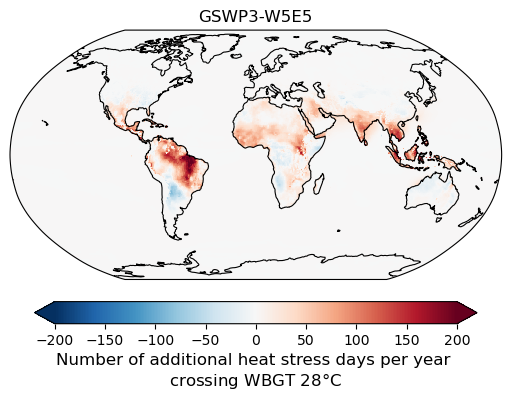

In [11]:
proj = ccrs.Robinson()
crs = ccrs.PlateCarree()

vmax = 200

# make figure object
fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'projection': proj},  layout='constrained')

data_plot = da_nAHD.isel(dataset=0)
plot = data_plot.plot( vmax=vmax, vmin=-vmax, cmap='RdBu_r', transform=crs, extend='both', add_colorbar=False)
ax.coastlines(color='black', linewidth=0.8)

cbar_lab = 'Number of additional heat stress days per year \ncrossing WBGT 28$\degree$C' # try to get TeX interpreter 'less likely $\leftarrow$ PR $\rightarrow$ more likely' #'PR' # add more/less likely arrow 
cbar = fig.colorbar(plot,  extend='both', ax=ax,  location='bottom',shrink=0.9) #, fraction= 0.045, pad= 0.04) #location='bottom' 
cbar.set_label(label=cbar_lab, size=12) 

plt.title(f'{data_plot.dataset.values}');
#ax.set_title('(a)',loc='left');

#plt.savefig(os.path.join(figdirs,f'fig_jun24_various/nAHD_isimip3a_{data_plot.dataset.values}_title.png'),dpi=300)


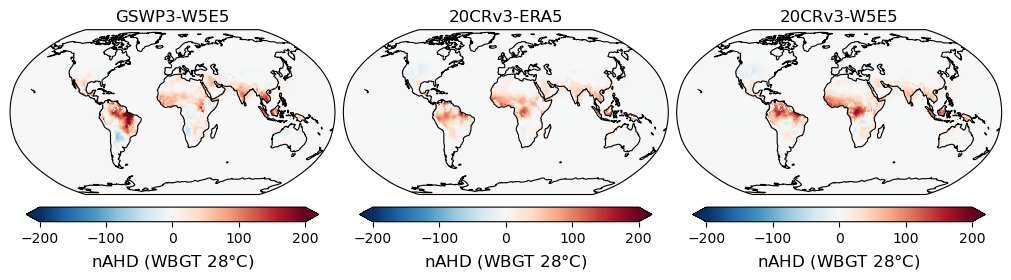

In [12]:
proj = ccrs.Robinson()
crs = ccrs.PlateCarree()

# make figure object
fig, axes = plt.subplots(1,3, figsize=(10,3), subplot_kw={'projection': proj},  layout='constrained')

vmax = 200

for i in range(3):
    data_plot = da_nAHD.isel(dataset=i)
    ax=axes[i]
    plot = data_plot.plot( vmax=vmax, vmin=-vmax, cmap='RdBu_r', transform=crs, extend='both', add_colorbar=False, ax=ax)
    ax.coastlines(color='black', linewidth=0.8)
    
    cbar_lab = 'nAHD (WBGT 28$\degree$C)' # try to get TeX interpreter 'less likely $\leftarrow$ PR $\rightarrow$ more likely' #'PR' # add more/less likely arrow 
    cbar = fig.colorbar(plot,  extend='both', ax=ax,  location='bottom',shrink=0.9) #, fraction= 0.045, pad= 0.04) #location='bottom' 
    cbar.set_label(label=cbar_lab, size=12) 
    
    ax.set_title(f'{data_plot.dataset.values}');

#plt.savefig(os.path.join(figdirs,f'fig_jun24_various/nAHD_isimip3a_all_v2.png'),dpi=300)


In [19]:
landmask = get_mask()

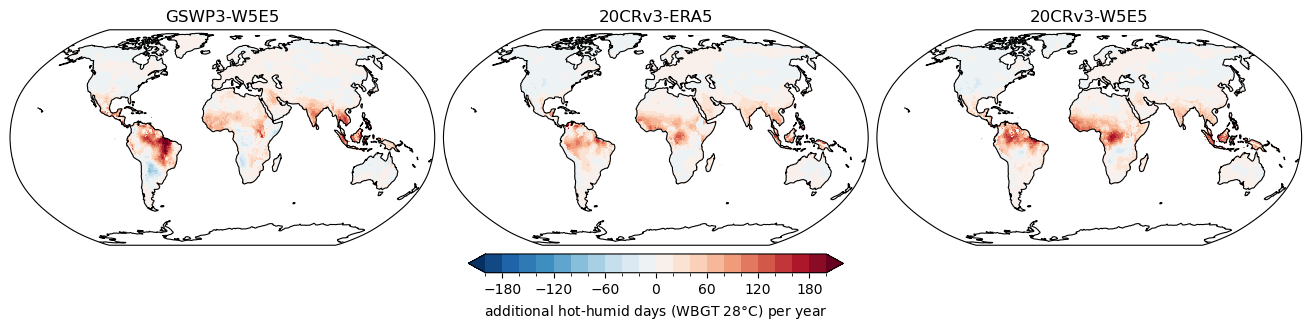

In [54]:
proj = ccrs.Robinson()
crs = ccrs.PlateCarree()

# make figure object
fig, axes = plt.subplots(1,3, figsize=(13,5), subplot_kw={'projection': proj},  layout='constrained')

vmax = 200

for i in range(3):
    data_plot = da_nAHD.isel(dataset=i) * landmask # include or not landmask ?? 
    ax=axes[i]
    plot = data_plot.plot( vmax=vmax, vmin=-vmax, cmap='RdBu_r', transform=crs, levels=21, extend='both', add_colorbar=False, ax=ax)
    ax.coastlines(color='black', linewidth=0.8)
    #ax.set_facecolor('#f0f0f0')
    ax.set_title(f'{data_plot.dataset.values}');
    
cbar_lab = 'additional hot-humid days (WBGT 28$\degree$C) per year' # try to get TeX interpreter 'less likely $\leftarrow$ PR $\rightarrow$ more likely' #'PR' # add more/less likely arrow 
cbar = fig.colorbar(plot,  extend='both', ax=axes,  location='bottom',shrink=0.3,fraction= 0.045,  pad= 0.02) #, fraction= 0.045, pad= 0.04) #location='bottom' 
cbar.set_label(label=cbar_lab) 
    
    

plt.savefig(os.path.join(figdirs,f'fig_jun24_various/nAHD_isimip3a_all_levels_land.png'),dpi=300)

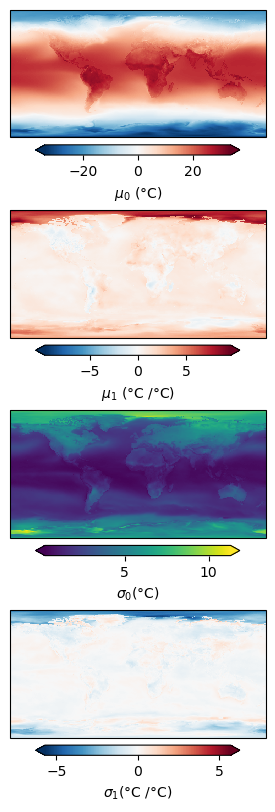

In [114]:
crs = ccrs.PlateCarree()

fig, axes = plt.subplots(4,1,figsize=(3,8), layout='constrained',subplot_kw={'projection': crs})

da_plot = da_params.isel(dataset=0,month=9)

for i in range(4):
    ax=axes[i]
    plot = da_plot.isel(params=i).plot(ax=ax,transform=crs,add_colorbar=False)   
    #ax.set_title(da_plot.params.values[i])
    ax.set_title('')
    cbar = fig.colorbar(plot,  extend='both', ax=ax,  location='bottom',shrink=0.7) 
    cbar_labels = ['$\mu_0$ ($\degree$C)','$\mu_1$ ($\degree$C /$\degree$C)',r'$\sigma_0 (\degree$C)',r'$\sigma_1 (\degree$C /$\degree$C)' ]
    cbar.set_label(label=cbar_labels[i], size=10) 

#plt.savefig(os.path.join(figdirs,f'fig_jun24_various/params_mo10_gswp3w5e5_v3.png'),dpi=300)
